In [58]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *


### 1. Simulating the data

In [59]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**4
n_host = 200

power_x, power_x_t = 1, 1
causal_param_first_index = 3
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 10 * T + 20* X[:,0]*T + 20* X[:,1]*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.beta(12, 3, size= n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
x_distributions= {0: X0, 1: X1}

p_assigned_to_host = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + T + eps)
p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + T + eps)
# p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 - 2*X_0 + eps)

Simulation parameters

In [60]:
# Prior parameters for Bayesian update on host
prior_mean = np.array([0, 1, 0, 1, 0, -10])
sigma_prior = 1

# Hyperparameters for Bayesian update on host
warmup_steps = 50
max_tree_depth = 5
sigma_rand_error = 1

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 50
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))

# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

### 2. EIG closed form for varying sample sizes

In [61]:
def eig_closed_form_varying_sample_size(n_both_candidates_list, proportion, n_rct_before_split, x_distributions, p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y):

    EIG_obs_closed_form_mirror, EIG_obs_closed_form_cand2 = [], []
    EIG_caus_closed_form_mirror, EIG_caus_closed_form_cand2 = [], []

    for length in n_both_candidates_list:

        X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
        design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, length, power_x, power_x_t, outcome_function, std_true_y)


        pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
        design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, proportion*length, \
                                            power_x, power_x_t, outcome_function, std_true_y)
        
        X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
        X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
        print(np.shape(X_mirror))
        
        # Initialize prior parameters
        beta_0, sigma_0_sq = prior_mean, 1
        prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
        bayes_reg = BayesianLinearRegression(prior_hyperparameters)

        ### Bayesian update through host dataset
        X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
        post_host_parameters = bayes_reg.fit(X_host, Y_host)
        beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
        cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']

        ## Bayesian update using the host dataset
        X_torch, Y_torch = torch.tensor(X_host.values), torch.tensor(Y_host.values)
        mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
                    mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
                    sigma_rand_error_fixed = True, n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)

        X_mirror_arr, X_cand2_arr = X_mirror.values, X_cand2.values

        EIG_obs_one_n_mirror = compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)
        EIG_obs_one_n_cand2 = compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

        EIG_obs_closed_form_mirror.append(EIG_obs_one_n_mirror)    
        EIG_obs_closed_form_cand2.append(EIG_obs_one_n_cand2)

        EIG_caus_one_n_mirror = compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host, sigma_rand_error, causal_param_first_index)
        EIG_caus_one_n_cand2 = compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, causal_param_first_index)

        EIG_caus_closed_form_mirror.append(EIG_caus_one_n_mirror)    
        EIG_caus_closed_form_cand2.append(EIG_caus_one_n_cand2)

    EIG_obs_closed_form = np.vstack((EIG_obs_closed_form_mirror,EIG_obs_closed_form_cand2 ))
    EIG_caus_closed_form = np.vstack((EIG_caus_closed_form_mirror,EIG_caus_closed_form_cand2 ))

    return EIG_obs_closed_form, EIG_caus_closed_form


In [72]:
n_both_candidates_list = [100, 200, 500]
proportion = 1.3 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


EIG_obs_closed_form, EIG_caus_closed_form = eig_closed_form_varying_sample_size(n_both_candidates_list, proportion, n_rct_before_split, x_distributions, p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y)

(100, 6)


Sample: 100%|██████████| 500/500 [00:20, 23.98it/s, step size=2.07e-02, acc. prob=0.803]


Inference ran for 0.35 minutes
(200, 6)


Sample: 100%|██████████| 500/500 [00:21, 23.60it/s, step size=1.75e-02, acc. prob=0.903]


Inference ran for 0.35 minutes
(500, 6)


Sample: 100%|██████████| 500/500 [00:21, 23.16it/s, step size=7.70e-03, acc. prob=0.936]

Inference ran for 0.36 minutes


In [69]:
EIG_caus_closed_form

array([[ 9.6444903 , 10.27440171, 10.38293807],
       [ 9.47666825,  9.99131537, 10.14145097]])

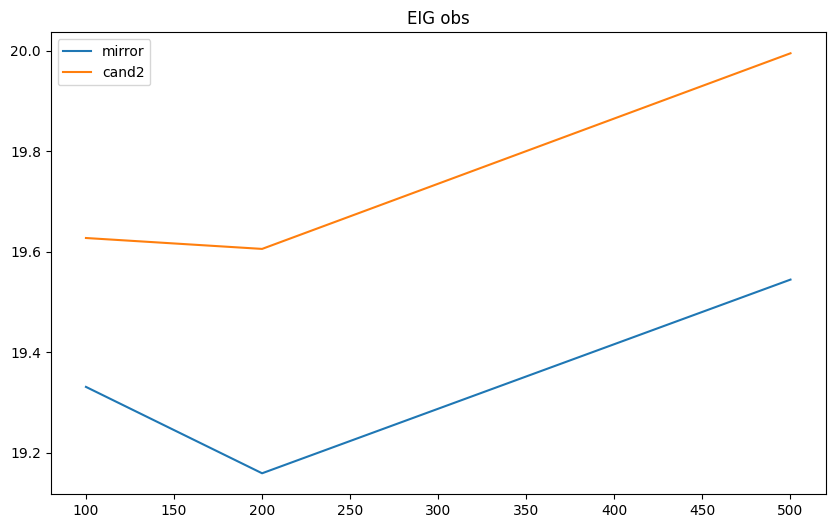

In [73]:
plot_array(n_both_candidates_list, EIG_obs_closed_form, names=['mirror','cand2'], title= 'EIG obs')

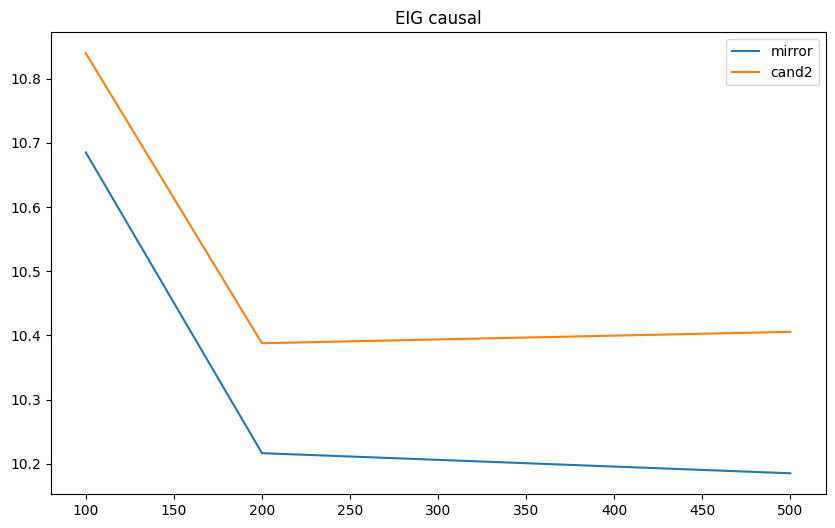

In [74]:
plot_array(n_both_candidates_list, EIG_caus_closed_form, names=['mirror','cand2'], title= 'EIG causal')

### 3. EIG from samples for varying sample sizes

In [66]:
def eig_from_samples_varying_sample_size(n_both_candidates_list, n_rct_before_split, x_distributions, p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y):

    EIG_obs_samples_mirror, EIG_obs_samples_cand2 = [], []
    EIG_caus_samples_mirror, EIG_caus_samples_cand2 = [], []

    for length in n_both_candidates_list:

        X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
        design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, length, power_x, power_x_t, outcome_function, std_true_y)


        pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
        design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, length, \
                                            power_x, power_x_t, outcome_function, std_true_y)
        
        X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
        X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
        print(np.shape(X_mirror))
        
        # Initialize prior parameters
        beta_0, sigma_0_sq = prior_mean, 1
        prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
        bayes_reg = BayesianLinearRegression(prior_hyperparameters)

        ### Bayesian update through host dataset
        X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
        post_host_parameters = bayes_reg.fit(X_host, Y_host)
        beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
        cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']

        ## Bayesian update using the host dataset
        X_torch, Y_torch = torch.tensor(X_host.values), torch.tensor(Y_host.values)
        mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model = model_normal,
                    mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
                    sigma_rand_error_fixed = True, n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)

        beta_post_host = pd.DataFrame(mcmc_host.get_samples())
        X_mirror_arr, X_cand2_arr = X_mirror.values, X_cand2.values

        ## obs

        Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)
        pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror, n_samples_for_expectation, m_samples_for_expectation)   

        Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)
        pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)  
        
        EIG_obs_one_n_mirror = compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)
        EIG_obs_one_n_cand2 = compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

        EIG_obs_samples_mirror.append(EIG_obs_one_n_mirror)    
        EIG_obs_samples_cand2.append(EIG_obs_one_n_cand2)

        ## causal

        sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
        
        pred_func = lambda beta: beta @ (X_mirror).T
        
        pred_in_causal_form_mirror = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)
        pred_in_causal_form_cand2 = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)


        EIG_caus_one_n_mirror = compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form_mirror, sigma_rand_error)
        EIG_caus_one_n_cand2 = compute_EIG_causal_from_samples(pred_list_cand2,pred_in_causal_form_cand2, sigma_rand_error)

        EIG_caus_samples_mirror.append(EIG_caus_one_n_mirror)    
        EIG_caus_samples_cand2.append(EIG_caus_one_n_cand2)

    EIG_obs_closed_form = np.vstack((EIG_obs_samples_mirror,EIG_obs_samples_cand2 ))
    EIG_caus_closed_form = np.vstack((EIG_caus_samples_mirror,EIG_caus_samples_cand2 ))

    return EIG_obs_closed_form, EIG_caus_closed_form

For both the mirror and cand2 datasets

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [67]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

NameError: name 'X_mirror' is not defined

In [ ]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

Now to calculate for the causal

In [ ]:
sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [ ]:
pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

In [ ]:
compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

Now, trying to calculate in closed form

In [ ]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

In [ ]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

For the cand2 dataset

In [ ]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [ ]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

Now, trying to calculate in closed form

In [ ]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

In [ ]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)